In [1]:
#####################################################################

In [2]:
run_experiments = False

In [3]:
import numpy as np
import random
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm as _tqdm
import gym
import argparse
import copy
from gridworld import GridworldEnv
from tqdm import tqdm
import pickle
import itertools

import time

from contextlib import contextmanager
import sys, os

from DQN_model import QNetwork
from DQN_replay import ReplayMemory
from DQN_policy import EpsilonGreedyPolicy, get_epsilon
from DQN_training import train
from DQN_plots import plot_smooth
from DQN_main import run_episodes

In [4]:
# From https://stackoverflow.com/questions/2125702/how-to-suppress-console-output-in-python
@contextmanager
def suppress_stdout(suppress):
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        if suppress:
            sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [5]:
def bin_lst(lst, halfbin=5):
    avgd = []
    for i in range(len(lst)):
        if i < halfbin:
            avgd.append(np.mean(lst[:i*2+1]))
        elif len(lst)-1-i < halfbin:
            diff = len(lst)-1-i
            avgd.append(np.mean(lst[i-diff:]))
        else:
            avgd.append(np.mean(lst[i-halfbin:i+halfbin]))
    return np.array(avgd)

In [6]:
def plot_with_error(losses, unc=True, filename=None, plot_label="Loss", y_label="Loss", colour='blue',
                    red_line=None, mean_only=False, lw=2, bin_it=None,alpha=0.5):
    losses = np.array(losses)

    
    means = np.mean(losses, axis=0)
    errors = np.std(losses, axis=0)
    
    if bin_it is not None:
        means = bin_lst(means, halfbin=bin_it)
        errors = bin_lst(errors, halfbin=bin_it)
    
    if unc: # Plot uncertainty instead of std
        errors = errors / np.sqrt(losses.shape[0])
    
    x = np.arange(len(means))
    plt.plot(x, means, lw=2, label=f"{plot_label}", color=colour, linewidth=lw)
    if not mean_only:
        plt.fill_between(x, means+errors, means-errors, facecolor=colour, alpha=alpha)

    return
        
def plot_multiple(multiple_losses, labels, filename=None, y_label="Loss",
                  red_line=None, br=False, legend_off=False, mean_only=False, title=None, 
                  lw=2, bin_it=None, unc=True, legend_next=False, xlims=(None,None),ylims=(None,None),
                 log_scale=False, xlabel_off=False,alpha=0.5): # Assumes multiple losses contains a set of loss_list's for each parameter
    fsize = 14
    tfsize = 15
    # File prepends should be a list of names
    colours = ['b', 'g', 'y', 'm', 'c', 'k', 'w']
    if title is not None:
        plt.title(title,fontsize=tfsize)
    
    for (losses, colour, label) in zip(multiple_losses, colours, labels):
        plot_with_error(losses, unc=unc, plot_label=label, y_label=y_label, colour=colour,
                         red_line=red_line, mean_only=mean_only, lw=lw, bin_it=bin_it, alpha=alpha)
    if red_line is not None:
        plt.axhline(y=red_line, color='r', linestyle='--', lw=lw, label="max|Q| limit")
    if log_scale:
        plt.yscale("log")
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.grid()
    if not xlabel_off:
        plt.xlabel("Episode",fontsize=fsize)
    else:
        locs, _ = plt.xticks()
        plt.xticks(locs, [])
        
    plt.xticks(fontsize=fsize)
    plt.yticks(fontsize=fsize)
    plt.ylabel(y_label,fontsize=fsize)
    if br and not legend_off:
        plt.legend(loc='upper right', fancybox=True, fontsize=fsize-1)
    elif not legend_off:
        if legend_next:
            plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), fancybox=True, fontsize=fsize-1)
        else:
            plt.legend(loc='upper left', fancybox=True, fontsize=fsize-1)
    if filename is not None:
        save_path = '../plots/'
        if not os.path.isdir(save_path):
            os.mkdir(save_path)
                
        plt.savefig(f"{save_path}/{filename}.pdf", format='pdf')

In [7]:
def pickle_tuple(tupl, filename='test'):
    save_path = '../pickles/'
    if not os.path.isdir(save_path):
        os.mkdir(save_path)
    with open(f"{save_path}/{filename}.pkl", 'wb') as f:
        pickle.dump(tupl,f)

def unpickle_tuple(filename='test'):
    save_path = '../pickles/'
    if not os.path.isdir(save_path):
        os.mkdir(save_path)
    with open(f"{save_path}/{filename}.pkl", 'rb') as f:
        return pickle.load(f)

In [8]:
def run_setting(env_name, num_episodes, batch_size, memory_size, discount_factor, learn_rate, seed, num_hidden, 
                min_eps, max_eps, anneal_time, clone_interval, clipping, suppress_printing):
    # mostly copied from main() in DQN_main.py, removed some code for overview
    # if you want replay to be turned off, use batch_size=memory_size=1
    # returns episode durations (list), losses averaged per step (list), max abs q averaged per step (list)
    
    env = GridworldEnv() if env_name == "GridWorldEnv" else gym.make(env_name)

    obs_shape = env.observation_space.shape
    num_actions = env.action_space.n
    if env_name == "Blackjack-v0":
        obs_size = 3
    elif len(obs_shape) > 0: 
        obs_size = obs_shape[0]
    else:
        obs_size = 1
#     obs_size = obs_shape[0] if len(obs_shape) > 0 else 1

    memory = ReplayMemory(memory_size)

    # for reproducibility
    random.seed(seed)
    torch.manual_seed(seed)
    env.seed(seed)

    Q_net = QNetwork(obs_size, num_actions, num_hidden=num_hidden)
    policy = EpsilonGreedyPolicy(Q_net, num_actions)
    with suppress_stdout(suppress_printing):
        return run_episodes(train, Q_net, policy, memory, env, num_episodes, batch_size, discount_factor, 
                            learn_rate, clone_interval, min_eps, max_eps, anneal_time, clipping)

In [9]:
# for each setting, edit below, and give an appropriate filename
if run_experiments:
    # Replay OFF, Target Network OFF
    settings = {
        'env_name':"CartPole-v1",
        'num_episodes':500,
        'batch_size':1, 
        'memory_size':1, 
        'discount_factor':0.8, 
        'learn_rate':1e-3, 
        'num_hidden':128, 
        'min_eps':0.05, 
        'max_eps':1., 
        'anneal_time':1000, 
        'clone_interval':None, 
        'clipping':True,
        'suppress_printing':True
    }

    start_ = time.time()
    durations_list_rF_tF, losses_list_rF_tF, max_Qs_list_rF_tF = [], [], []
    for seed in tqdm(range(1,11)):
        durations, losses, max_Qs = run_setting(**settings, seed=seed)
        durations_list_rF_tF.append(durations)
        losses_list_rF_tF.append(losses)
        max_Qs_list_rF_tF.append(max_Qs)
    filename = f"CartPole-v1_replay_off_tn_off_gamma08"
    pickle_tuple((durations_list_rF_tF, losses_list_rF_tF, max_Qs_list_rF_tF, settings), filename=filename)
    print((time.time() - start_)/60, "min")

In [10]:
# for each setting, edit below, and give an appropriate filename
bs = [5,50,64,64]
ms = [5,50,500,5000]
if run_experiments:
    # Replay ON, Target Network OFF
    settings = {
        'env_name':"CartPole-v1",
        'num_episodes':500,
        'batch_size':64, 
        'memory_size':50000, 
        'discount_factor':0.8, 
        'learn_rate':1e-3, 
        'num_hidden':128, 
        'min_eps':0.05, 
        'max_eps':1., 
        'anneal_time':1000, 
        'clone_interval':None, 
        'clipping':True,
        'suppress_printing':True
    }
    for b,m in zip(bs,ms):
        start_ = time.time()
        settings["batch_size"] = b
        settings["memory_size"] = m
        durations_list_rT_tF, losses_list_rT_tF, max_Qs_list_rT_tF = [], [], []
        for seed in tqdm(range(1,11)):
            durations, losses, max_Qs = run_setting(**settings, seed=seed)
            durations_list_rT_tF.append(durations)
            losses_list_rT_tF.append(losses)
            max_Qs_list_rT_tF.append(max_Qs)
        filename = f"CartPole-v1_replay{m}_on_tn_off_gamma08"
        pickle_tuple((durations_list_rT_tF, losses_list_rT_tF, max_Qs_list_rT_tF, settings), filename=filename)
        print((time.time() - start_)/60, "min")

In [11]:
# for each setting, edit below, and give an appropriate filename
t_values = [500]

if run_experiments:
    # Replay OFF, Target Network ON
    settings = {
        'env_name':"CartPole-v1",
        'num_episodes':500,
        'batch_size':1, 
        'memory_size':1, 
        'discount_factor':0.8, 
        'learn_rate':1e-3, 
        'num_hidden':128, 
        'min_eps':0.05, 
        'max_eps':1., 
        'anneal_time':1000,
        'clipping':True,
        'suppress_printing':True
    }
    
    for t in t_values:
        start_ = time.time()
        settings["clone_interval"] = t
        durations_list_rF_tT, losses_list_rF_tT, max_Qs_list_rF_tT = [], [], []
        for seed in tqdm(range(1,11)):
            durations, losses, max_Qs = run_setting(**settings, seed=seed)
            durations_list_rF_tT.append(durations)
            losses_list_rF_tT.append(losses)
            max_Qs_list_rF_tT.append(max_Qs)
        filename = f"CartPole-v1_replay_off_tn{t}_on_gamma08"
        pickle_tuple((durations_list_rF_tT, losses_list_rF_tT, max_Qs_list_rF_tT, settings), filename=filename)
        print((time.time() - start_)/60, "min")

In [12]:
# for each setting, edit below, and give an appropriate filename
t_values = [500]

if run_experiments:
    # Replay ON, Target Network ON
    settings = {
        'env_name':"CartPole-v1",
        'num_episodes':500,
        'batch_size':64, 
        'memory_size':50000, 
        'discount_factor':0.8, 
        'learn_rate':1e-3, 
        'num_hidden':128, 
        'min_eps':0.05, 
        'max_eps':1., 
        'anneal_time':1000,
        'clipping':True,
        'suppress_printing':True
    }
    
    for t in t_values:
        for b,m in zip(bs,ms):
            start_ = time.time()
            settings["batch_size"] = b
            settings["memory_size"] = m
            settings["clone_interval"] = t
            durations_list_rT_tT, losses_list_rT_tT, max_Qs_list_rT_tT = [], [], []
            for seed in tqdm(range(1,11)):
                durations, losses, max_Qs = run_setting(**settings, seed=seed)
                durations_list_rT_tT.append(durations)
                losses_list_rT_tT.append(losses)
                max_Qs_list_rT_tT.append(max_Qs)
            filename = f"CartPole-v1_replay{m}_on_tn{t}_on_gamma08"
            pickle_tuple((durations_list_rT_tT, losses_list_rT_tT, max_Qs_list_rT_tT, settings), filename=filename)
            print((time.time() - start_)/60, "min")

In [13]:
# RESULTS - PLOTS 

/Users/Yke/Desktop/AI/Year2/RL/venv/miniconda3/envs/rl2020/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.


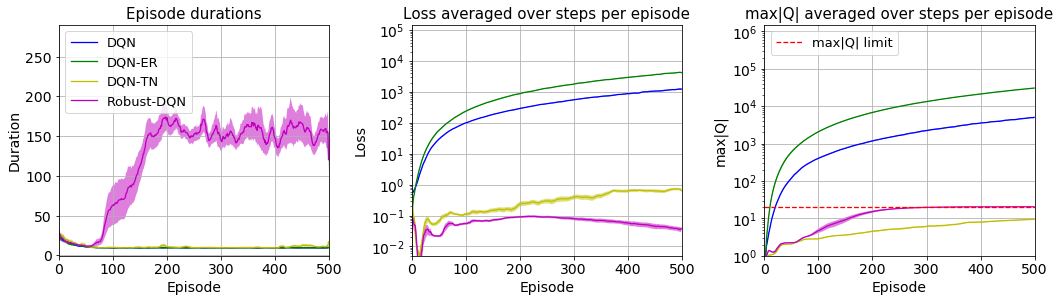

In [14]:
# effect replay-target OFF-OFF / ON-OFF / OFF-ON / ON-ON
# for gamma = 0.95

data095 = {"r-on":{},"r-off":{}}
for r in ["on","off"]:
    for t in ["on","off"]:
        tn = "500_on" if t == "on" else "_"+t
        fname = f"CartPole-v1_replay_{r}_tn{tn}_gamma095"
        data095[f"r-{r}"][f"t-{t}"] = unpickle_tuple(filename=fname)

ylabels = ["Duration", "Loss", "max|Q|"]
titles = ["Episode durations", "Loss averaged over steps per episode", "max|Q| averaged over steps per episode"]
ylims = [(None,290), (5e-3,1.5e5), (1,1.5e6)]
log_scales = [False, True, True]
red_lines = [None, None, 20]
legend_off = [False, True, False]

plt.figure(figsize=(15,4.3))
for i in range(3):
    plt.subplot(1,3,i+1)
    data = [data095["r-off"]["t-off"][i], data095["r-on"]["t-off"][i], 
            data095["r-off"]["t-on"][i], data095["r-on"]["t-on"][i]]
    labels = ["DQN", "DQN-ER", "DQN-TN", "Robust-DQN"]
    labels = [""]*4 if i == 2 else labels
    plot_multiple(data, labels, y_label=ylabels[i], mean_only=False, 
              title=titles[i], lw=1.3, bin_it=5, log_scale=log_scales[i], 
                  ylims=ylims[i], red_line=red_lines[i], xlims=(0,500), legend_off=legend_off[i])

plt.tight_layout()     
plt.savefig("../plots/cartpole-divergence.pdf")
plt.show()

/Users/Yke/Desktop/AI/Year2/RL/venv/miniconda3/envs/rl2020/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.


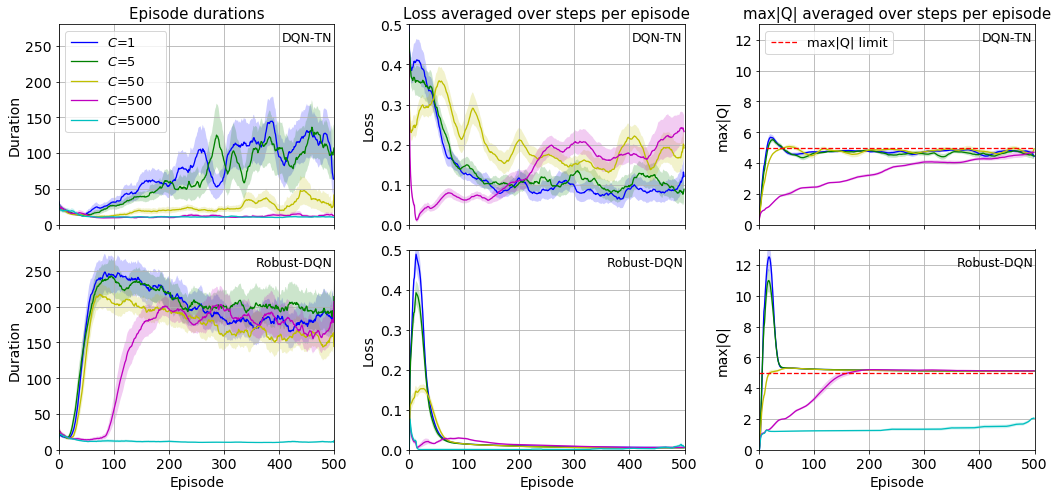

In [15]:
# effect of target-network update frequency for replay ON / OFF
# for gamma = 0.8

t_settings = ["5","50","500","5000"]
data = {"r-on":{},"r-off":{}}
for r in ["on", "off"]:
    for t in ["_off"]+[t_setting+"_on" for t_setting in t_settings]:
        fname = f"CartPole-v1_replay_{r}_tn{t}_gamma08"
        t_setting = t.split("_")[0] if t.split("_")[0] != "" else "1"
        data[f"r-{r}"][f"t-{t_setting}"] = unpickle_tuple(filename=fname)
        
ylabels = ["Duration", "Loss", "max|Q|"]
titles = ["Episode durations","Loss averaged over steps per episode","max|Q| averaged over steps per episode"]
t_settings = ["1","5","50","500","5000"]
ylims = [(0,280), (0,0.5), (0,13)]
red_lines=[None,None,5]

cols = 3
plt.figure(figsize=(cols*5,7))
for i in range(cols):
    plt.subplot(2,cols,1+i)
    plt_data = [data["r-off"][f"t-{t}"][i] for t in t_settings]
    labels = [f"$C$={t}" for t in t_settings]
    labels = [""]*4 if i > 0 else labels
    plot_multiple(plt_data, labels, y_label=ylabels[i], mean_only=False,
                      title=titles[i], lw=1.3, bin_it=10, log_scale=False,
                      legend_off=i==1, ylims=ylims[i], xlims=(0,500), xlabel_off=True, alpha=0.2,red_line=red_lines[i])
    plt.text(405,ylims[i][1]/5.*4.6,"DQN-TN",fontsize=12.5)
    plt.subplot(2,cols,cols+1+i)
    plt_data = [data["r-on"][f"t-{t}"][i] for t in t_settings]
    labels = [f"$C$={t}" for t in t_settings]
    plot_multiple(plt_data, labels, y_label=ylabels[i], mean_only=False,
                      title=None, lw=1.3, bin_it=10, log_scale=False,
                      legend_off=True, ylims=ylims[i], xlims=(0,500), xlabel_off=False, alpha=0.2,red_line=red_lines[i])
    plt.text(358,ylims[i][1]/5.*4.6,"Robust-DQN",fontsize=12.5)
plt.tight_layout()
plt.savefig("../plots/cartpole-tn-test.pdf")

/Users/Yke/Desktop/AI/Year2/RL/venv/miniconda3/envs/rl2020/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.


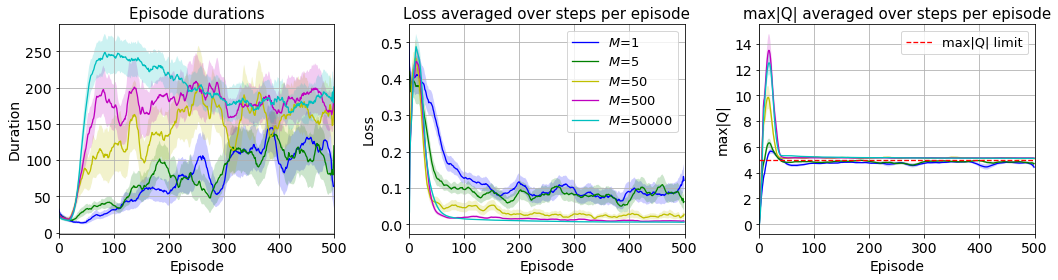

In [16]:
# effect of replay memory (target net = OFF)

r_settings = ["5","50","500","5000"]
data = {"t-on":{},"t-off":{}}
for t in ["off"]:#["on", "off"]:
    print()
    for r in ["_off"]+[r_setting+"_on" for r_setting in r_settings]+["_on"]:
        tn = f"500_{t}" if t == "on" else f"_{t}"
        fname = f"CartPole-v1_replay{r}_tn{tn}_gamma08"    
        r_setting = r.split("_")[0] if r.split("_")[0] != "" else "50000"
        r_setting = 1 if r=="_off" else r_setting
        data[f"t-{t}"][f"r-{r_setting}"] = unpickle_tuple(filename=fname)
        
ylabels = ["Duration", "Loss", "max|Q|"]
titles = ["Episode durations","Loss averaged over steps per episode","max|Q| averaged over steps per episode"]
r_settings = ["1","5","50","500","5000", "50000"]
# ylims = [(0,280), (0,0.5), (0,13)]
ylims = [(None,None)]*3
red_lines=[None,None,5]

cols = 3
plt.figure(figsize=(cols*5,4))
for i in range(cols):
    plt.subplot(1,cols,1+i)
    plt_data = [data["t-off"][f"r-{r}"][i] for r in r_settings]
    plt_data = [plt_data[0], plt_data[1], plt_data[2], plt_data[3], plt_data[5]]
    labels = [f"$M$={r}" for r in r_settings]
    labels = [labels[0], labels[1], labels[2], labels[3], labels[5]] if i!=2 else [""]*5
    plot_multiple(plt_data, labels, y_label=ylabels[i], mean_only=False,
                      title=titles[i], lw=1.3, bin_it=10, log_scale=False,
                      legend_off=i==0, ylims=ylims[i], xlims=(0,500), xlabel_off=False, alpha=0.2, br=1,
                     red_line=red_lines[i])

plt.tight_layout()
plt.savefig("../plots/cartpole-memory-test.pdf")

In [17]:
###########################################################################